## Wstęp 

Na ostatnich zajęciach wprowadziliśmy pojęcie perceptronu. Skorzystaliśmy z niego jako najprostsze narzędzie do klasyfikacji. Natomiast na tych zajęciach, będziemy badać jak wiele perceptronów pordzi sobie z problemami, które niekoniecznie cechują się danymi liniowo separowalnymi.

## Zadanie 1
Zadanie polegało na stworzeniu modelu z wieloma warstwami neuronów (MLP), który za zadanie miał ocenić skuteczność leku.


Na początku zaimportowano wszystkie niezbędne biblioteki i wczytano dane z pliku

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import time as tm
import warnings
import seaborn as sns

def_path = os.getcwd()
warnings.filterwarnings("ignore")

DataFrame = pd.read_csv(f"{def_path}/data/medicine.txt", delimiter=',')
data_array = DataFrame.to_numpy()

Następnie usunięto outliery za pomocą metody Tukeya

In [2]:
Q1_1 = np.percentile(data_array[:, 0], 25)
Q3_1 = np.percentile(data_array[:, 0], 75)
IQR_1 = Q3_1 - Q1_1

lower_bound_1 = Q1_1 - 1.5 * IQR_1
upper_bound_1 = Q3_1 + 1.5 * IQR_1

data_array_filtered = data_array[(data_array[:, 0] > lower_bound_1) & (data_array[:, 0] < upper_bound_1)]

Q1_2 = np.percentile(data_array_filtered[:, 1], 25)
Q3_2 = np.percentile(data_array_filtered[:, 1], 75)
IQR_2 = Q3_2 - Q1_2

lower_bound_2 = Q1_2 - 1.5 * IQR_2
upper_bound_2 = Q3_2 + 1.5 * IQR_2

data_array_final = data_array_filtered[
    (data_array_filtered[:, 1] > lower_bound_2) & (data_array_filtered[:, 1] < upper_bound_2)]

print("Oryginalny rozmiar:", data_array.shape)
print("Po usunięciu odstających w pierwszej kolumnie:", data_array_filtered.shape)
print("Po usunięciu odstających w drugiej kolumnie:", data_array_final.shape)


Oryginalny rozmiar: (1350, 3)
Po usunięciu odstających w pierwszej kolumnie: (1286, 3)
Po usunięciu odstających w drugiej kolumnie: (1285, 3)


Teraz znormalizowano dane za pomocą reguły MinMax

In [3]:
yf = data_array_final[:, 2]
Xf = data_array_final[:, :-1]

X_min = Xf.min(axis=0)
X_max = Xf.max(axis=0)
X_minmax_final = (Xf - X_min) / (X_max - X_min)


Xf_train, Xf_test, yf_train, yf_test = sk.model_selection.train_test_split(
    X_minmax_final, yf, test_size=0.2, stratify=yf
)

Zdefiniowano funkcje, która posłuży do rysowania wykresu przedstawiającego linie decyzyjności modelu.

In [4]:
def plot_decision_boundary(model, X, y, ax):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')

Następnie zdefiniowano tablice zaweirająco kolejne testowane przeze mnie struktury sieci neuronowej użyte podczas nauki modelu.

In [5]:
architectures = [
    (3,),
    (50,),
    (2, 2),
    (100,),
    (1000, 1000),
    (300, 200, 100),
    (50, 50, 50),
    (2, 2, 2, 2, 2, 2, 2, 2, 2),
]

Iterujemy przez wszystkie zdefiniowane przeze mnie konfiguracje oraz rysujemy wykres wraz z metrykami.

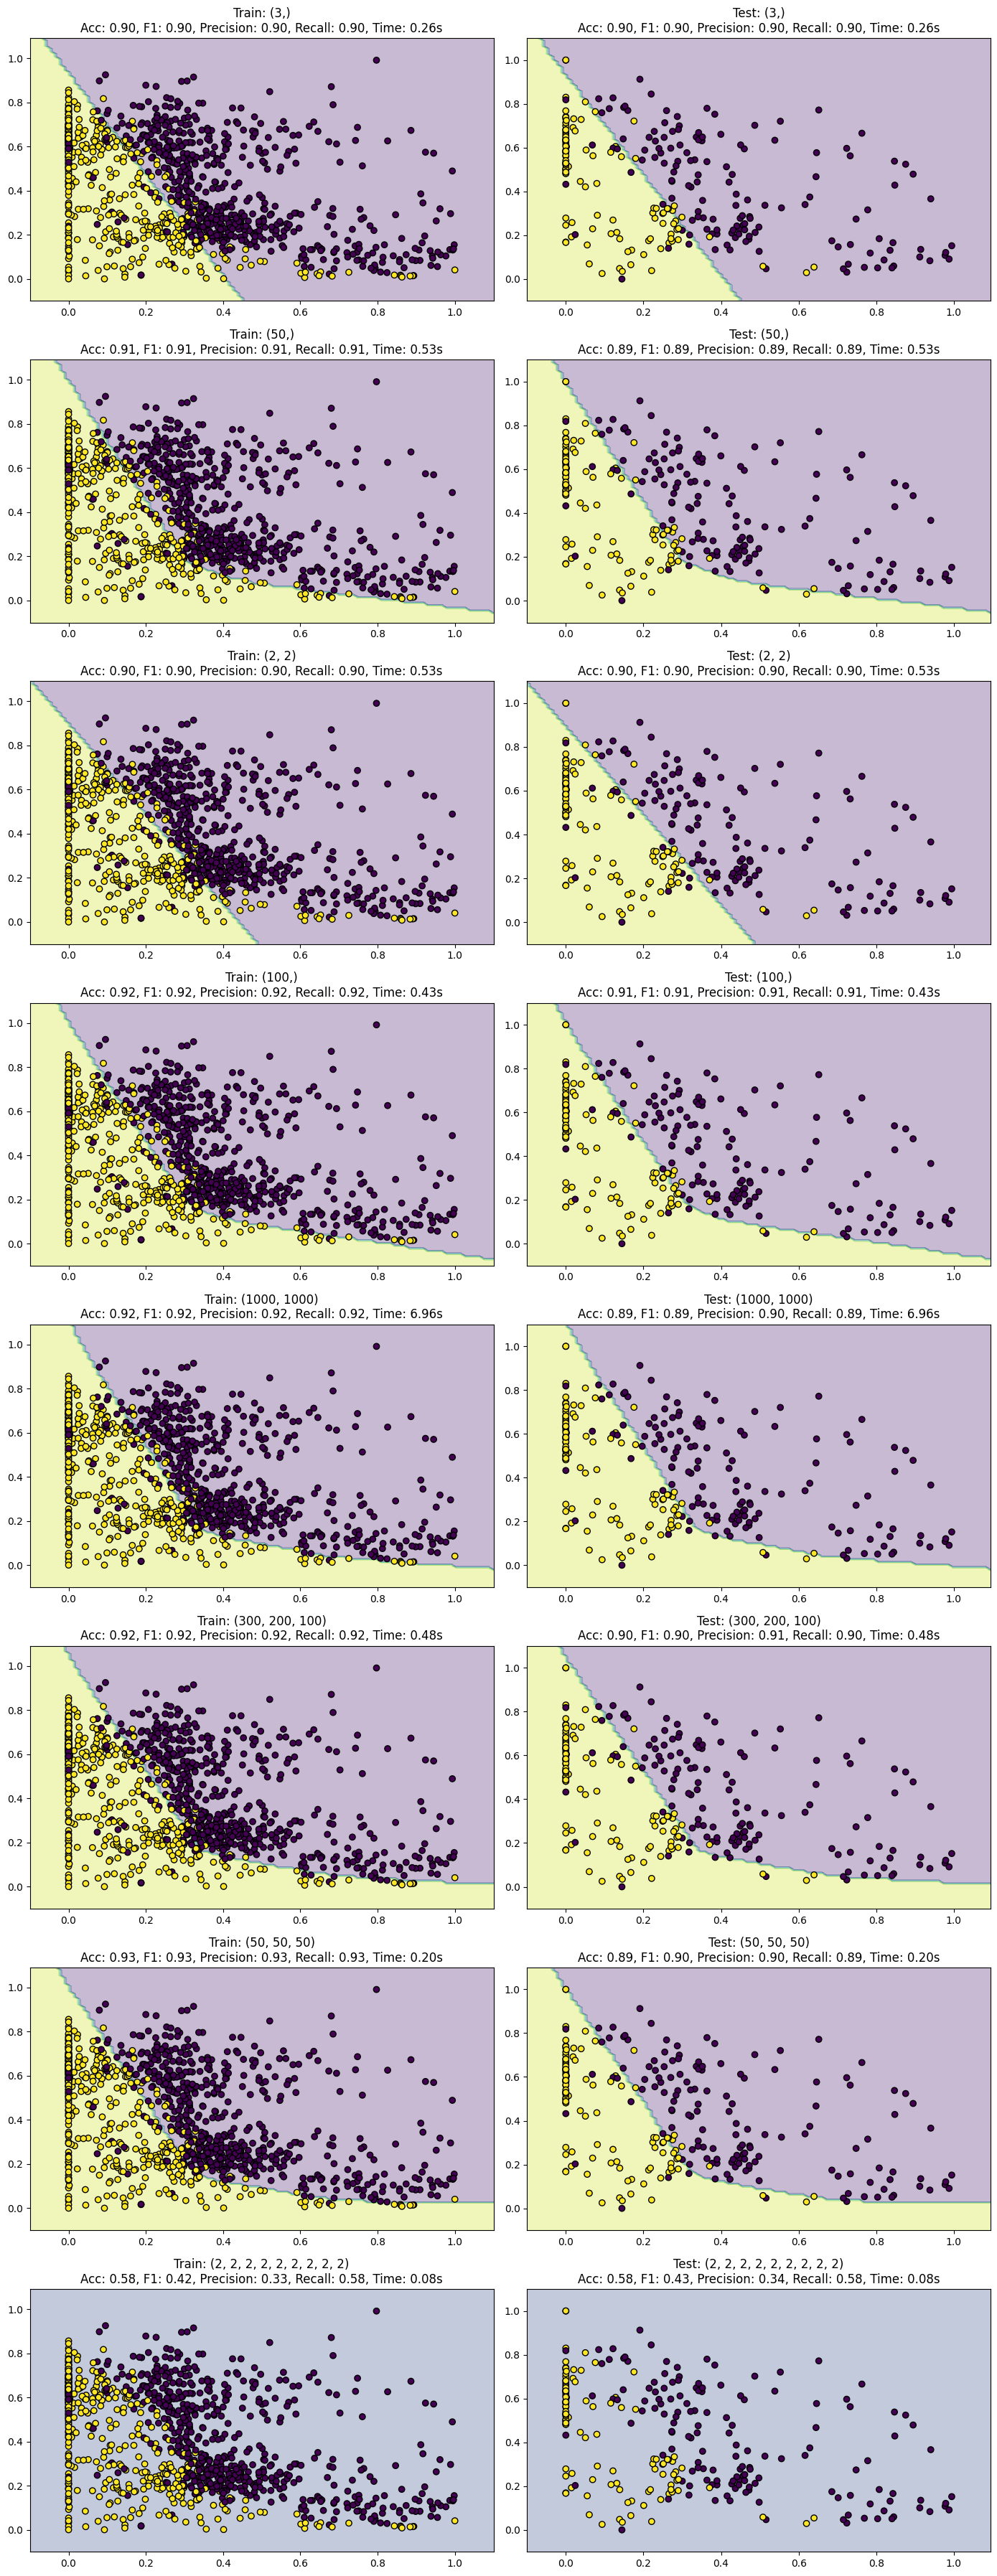

In [6]:
fig, axes = plt.subplots(len(architectures), 2, figsize=(14, 36))  
axes = np.array(axes)  

for i, arch in enumerate(architectures):

    model = sk.neural_network.MLPClassifier(hidden_layer_sizes=arch, max_iter=2000, random_state=42)
    start = tm.time()
    model.fit(Xf_train, yf_train)
    end = tm.time()

    # TESTOWE
    y_test_pred = model.predict(Xf_test)
    acc_test = sk.metrics.accuracy_score(yf_test, y_test_pred)
    f1_test = sk.metrics.f1_score(yf_test, y_test_pred, average='weighted')
    precision_test = sk.metrics.precision_score(yf_test, y_test_pred, average='weighted')  # Precyzja
    recall_test = sk.metrics.recall_score(yf_test, y_test_pred, average='weighted')
    plot_decision_boundary(model, Xf_test, yf_test, axes[i, 1])
    axes[i, 1].set_title(f"Test: {arch}\nAcc: {acc_test:.2f}, F1: {f1_test:.2f}, Precision: {precision_test:.2f}, Recall: {recall_test:.2f}, Time: {end-start:.2f}s")

    # TRENINGOWE
    y_train_pred = model.predict(Xf_train)
    acc_test = sk.metrics.accuracy_score(yf_train, y_train_pred)
    f1_test = sk.metrics.f1_score(yf_train, y_train_pred, average='weighted')
    precision_test = sk.metrics.precision_score(yf_train, y_train_pred, average='weighted')  # Precyzja
    recall_test = sk.metrics.recall_score(yf_train, y_train_pred, average='weighted')
    plot_decision_boundary(model, Xf_train, yf_train, axes[i, 0])
    axes[i, 0].set_title(f"Train: {arch}\nAcc: {acc_test:.2f}, F1: {f1_test:.2f}, Precision: {precision_test:.2f}, Recall: {recall_test:.2f}, Time: {end-start:.2f}s")

plt.tight_layout()
plt.show()

### Wnioski

Z wyników widać, że podział poprawia się wraz ze wzrostem ilości warstwa oraz ilości neuronów w warstwie. Natomiast są przypadki, które należałoby wyszczególnić.

- (3,) oraz (2,2) tutaj jasno widać, że podział przybrał postać liniowego podobnego do poprzednich zajęć, gdzie używaliśmy pojedyńczego perceptronu. Liniowa granica decyzyjna spowodowała trochę gorsze wyniki od innych architektur, gdzie linia była bardziej dopasowana.
- (50,) , (100,) , (1000,1000,) , (300,200,100,) , (50,50,50,) w tym przypadku widać, że nasza granica decyzyjna przybrała nieco inny kształt bardziej dopasowując się do danych uczących. Uzyskaliśmy tutaj nieco lepsze wyniki. Widać, że większa liczba perceptronów zdecydowanie wpłynęła na wyniki..
- (2,2,2,2,2,2,2,2,2) przy tak dużej ilości warstw z tak małą liczbą perceptronów w każdej uzyskaliśmy bardzo ciekawy wynik. Model dopasował wszystkie dane do jednej klasy, co doprowadziło do niskiej skuteczności modelu. 

Dodatkowo zmierzyliśmy czas wykonywania trenowania modelu i można zauważyć, że architektura (1000,1000) uzyskała czas treningu ponad 7 sekund, co jest wynikiem najgorszym z uzyskanych.

## Zadanie 2/3
Kolejnym zadaniem było stworzenie modelu dla zbioru danych, które zawierały odrecznie zapisane liczby. Dane wejściowe zawierały 64 parametry o wartościach od 0 do 16. Gdzie parametry te odpowiadają za jasność pixela w obrazie cyfry.
Stworzyliśmy model MLP i również testowaliśmy wiele różnych architektur sieci. Zmienialiśmy strukturę sieci, ilość epok uczenia, funkcje aktywacji oraz współczynnik uczenia.

In [13]:
X = sk.datasets.load_digits()['data']
y = sk.datasets.load_digits()['target']
X_norm = X / 16.0


X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X_norm, y, test_size=0.2, stratify=y
)

Zdefiniowaliśmy listę słowników, która zawierała różne konfiguracje eksperymentów

In [16]:
experiments = [
    {'arch': (100,), 'activation': 'relu', 'solver': 'adam', 'epochs': 1000},
    {'arch': (100,), 'activation': 'relu', 'solver': 'adam', 'epochs': 1},
    {'arch': (2,), 'activation': 'relu', 'solver': 'adam', 'epochs': 1000},
    {'arch': (100,), 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.1, 'epochs': 1000},
    {'arch': (50, 50), 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.01, 'epochs': 1000},
    {'arch': (200, 100, 50), 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.001, 'epochs': 1000},
    {'arch': (100, 100), 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 1.0, 'epochs': 1000},
    {'arch': (100,), 'activation': 'tanh', 'solver': 'adam', 'epochs': 1000},
    {'arch': (300,), 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.05, 'epochs': 1000},
]

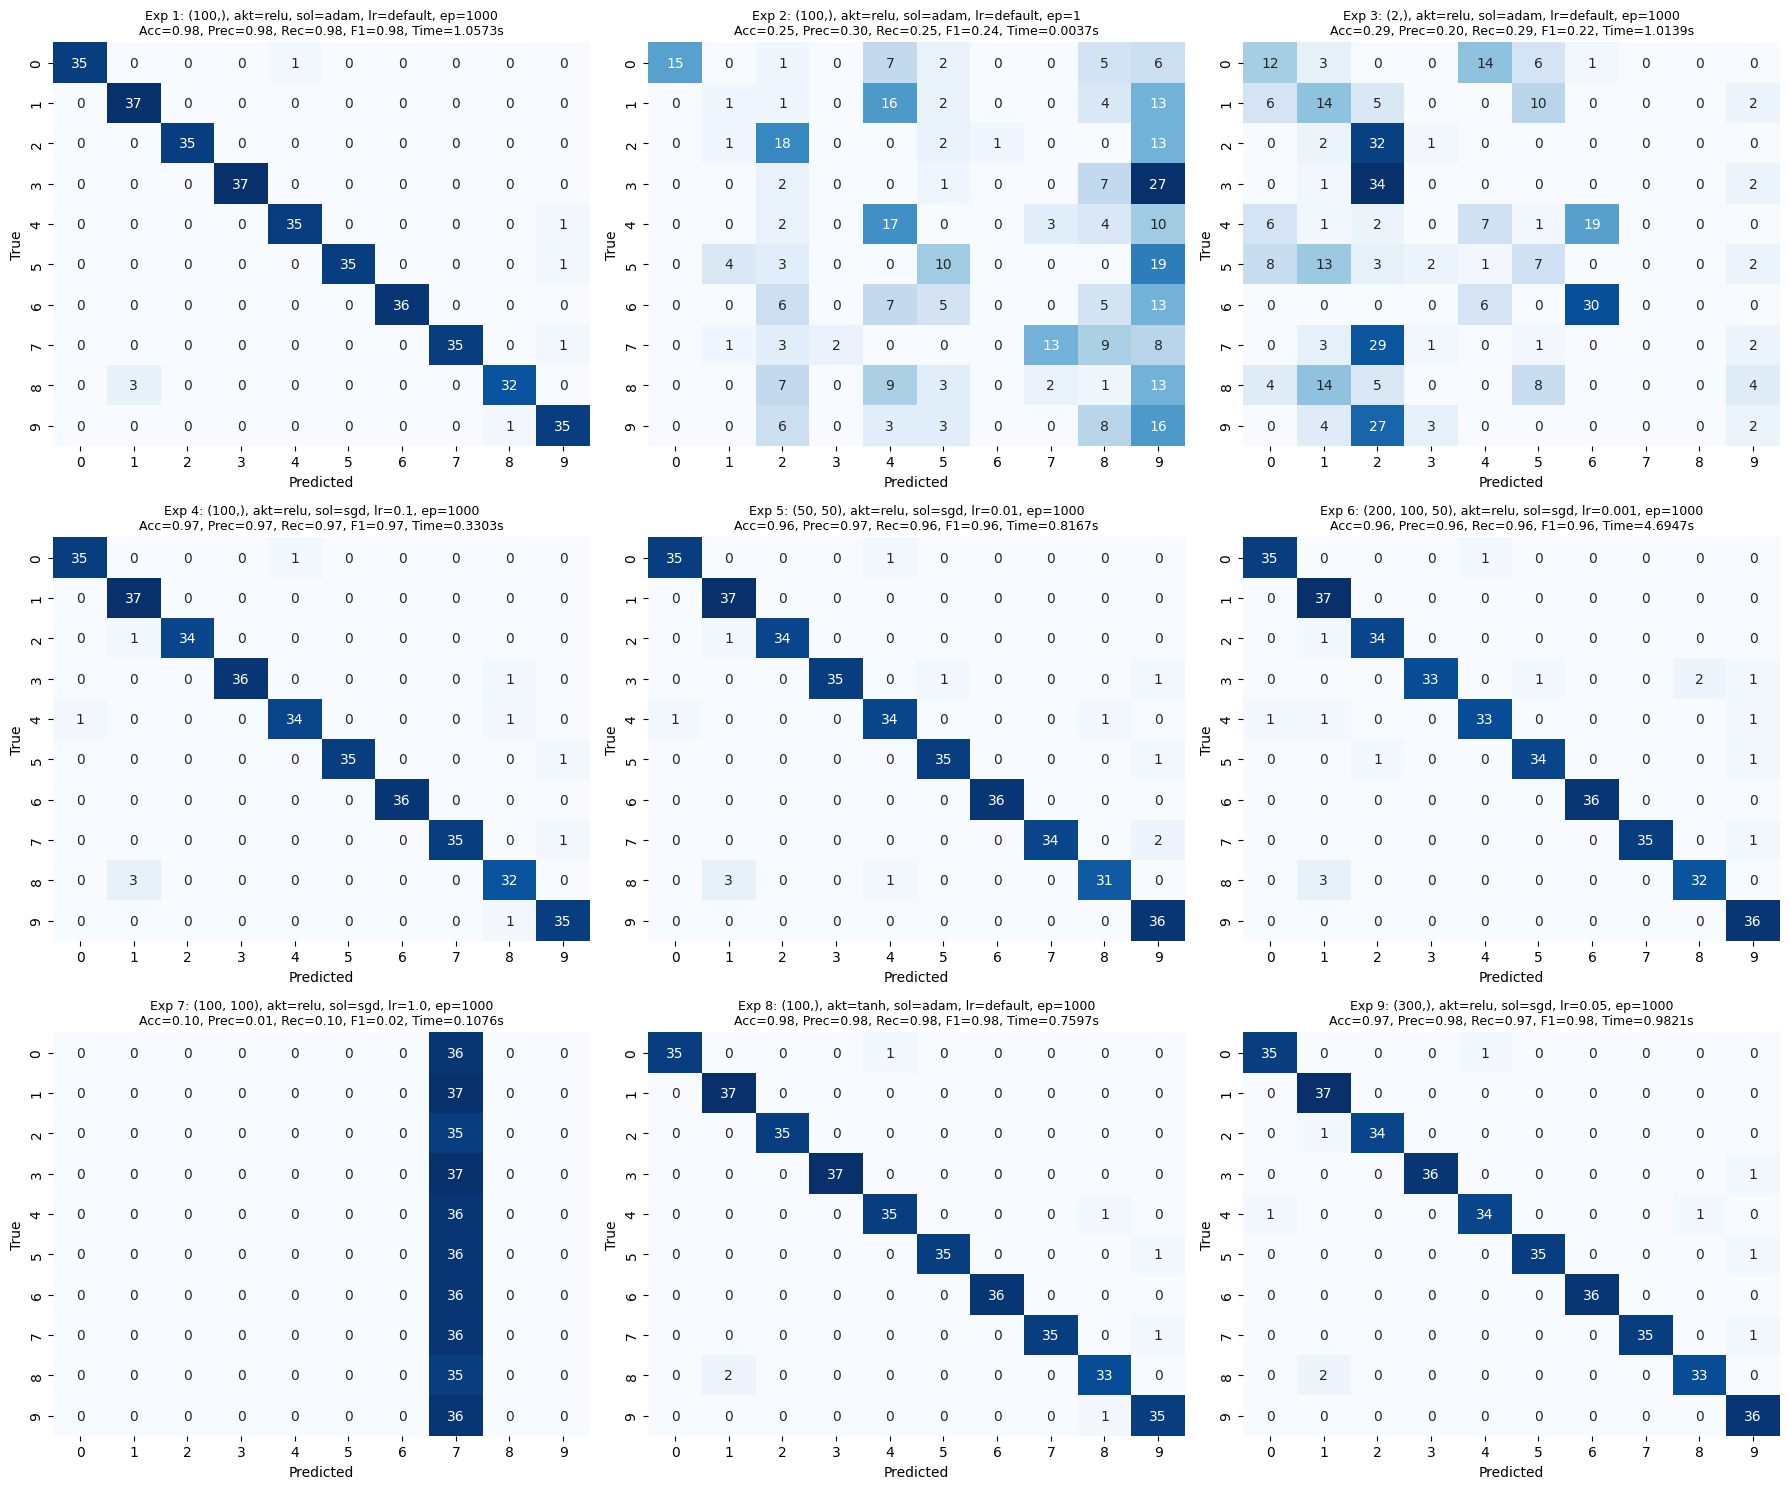

In [17]:
num_experiments = len(experiments)
cols = 3
rows = (num_experiments + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

results = []

for i, (exp, ax) in enumerate(zip(experiments, axes), 1):
    model = sk.neural_network.MLPClassifier(
        hidden_layer_sizes=exp['arch'],
        activation=exp['activation'],
        solver=exp['solver'],
        learning_rate_init=exp.get('learning_rate_init', 0.001),
        max_iter=exp['epochs'],
        random_state=42,
        early_stopping=False
    )

    start = tm.time()
    model.fit(X_train, y_train)
    end = tm.time()
    training_time = round(end - start, 4)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    acc = sk.metrics.accuracy_score(y_test, y_test_pred)
    prec = sk.metrics.precision_score(y_test, y_test_pred, average='weighted')
    rec = sk.metrics.recall_score(y_test, y_test_pred, average='weighted')
    f1 = sk.metrics.f1_score(y_test, y_test_pred, average='weighted')

    cm = sk.metrics.confusion_matrix(y_test, y_test_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax, cbar=False)
    ax.set_title(
        f"Exp {i}: {exp['arch']}, akt={exp['activation']}, sol={exp['solver']}, "
        f"lr={exp.get('learning_rate_init', 'default')}, ep={exp['epochs']}\n"
        f"Acc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, F1={f1:.2f}, Time={training_time}s",
        fontsize=9
    )
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    results.append({
        'Exp': i,
        'Arch': str(exp['arch']),
        'Akt': exp['activation'],
        'Sol': exp['solver'],
        'LR': exp.get('learning_rate_init', 'default'),
        'Epochs': exp['epochs'],
        'Train Acc': sk.metrics.accuracy_score(y_train, y_train_pred),
        'Test Acc': acc,
        'Test Precision': prec,
        'Test Recall': rec,
        'Test F1': f1,
        'Training Time': training_time,
    })



fig.tight_layout()
plt.savefig("macierze_pomylek.png", dpi=300)
plt.show()

## Wnioski

W tym badaniu sprawdzaliśmy wpływ architektóry, ilośc epok uczeniu, typ funkcji aktywacji, współczynnika uczenia oraz algorytmów uczenia na nasz model. Wygenerowano 9 macierzy pomyłek, które obrazują efekty uczenia naszenia modelu. 
- Zbyt mała ilość epok uczenia znacząco obniża skuteczność modelu.
- Zbyt wysoki współczynnik uczenia dla algorytmu sgd również bardzo obniża skuteczność modelu.
- Zbyt niski współczynnik uczenia znacząco wydłuża uczenie modelu.
- Zbyt mała ilość perceptronów (2,) była nie wystarczająca aby uzyskać dobre dopasowanie.
Jeśli odrzucimy skrajne przypadki można uznać, że wielowarstwowa architektura perceptronów bez względu na wybraną funkcje aktywacji lub algorytm uczenia poradziła sobie dobrze z dopasowaniem danych testowych. F1 score > 98

## Zadanie 4
W tym zadaniu tworzymy model, który dopasowuje typ drożdży na podstawie danych parametrów. Dane są bardzo zaburzone. Nie są proporcjonalne -> niektóre typy drożdży posiadają wiele wystąpień natomiast inne pojawiają się tylko kilka razy. Dodatkowo w zbiorze są parametry, które w większości posiadają stałą wartość (parametr nr 5 i 6). W związku z tym uporządkowanie danych wymagało odpowiedniej staranności.

Pobrano dane i usunięto outliery ignorując parametry nr 5 i 6. Dodatkowo wzięto pod uwagę, że liczba outlierów jest bardzo dużo i nie chcąć usunąć zbyt wielu danych wprowadzono warunek, że usuwamy dane, w przypadku dwóch lub więcej outlierów.

In [32]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
yeast = fetch_ucirepo(id=110)

# data (as pandas dataframes)
X = yeast.data.features
y = yeast.data.targets


X = X.to_numpy()
y = y.to_numpy()

outlier_counts = np.ones(X.shape[0], dtype=int)


# Outliery
for i in range(X.shape[1]):
    if i in [4, 5]:
        break
    Q1 = np.percentile(X[:, i], 25)
    Q3 = np.percentile(X[:, i], 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.8 * IQR
    upper_bound = Q3 + 1.8 * IQR

    outlier_mask = (X[:, i] < lower_bound) | (X[:, i] > upper_bound)
    outlier_counts += outlier_mask

mask = outlier_counts < 2
Xf = X[mask]
yf = y[mask]
yf = yf.ravel()

print(f"Oryginalny rozmiar: {X.shape}")
print(f"Po usunięciu outlierów: {Xf.shape}")

Oryginalny rozmiar: (1484, 8)
Po usunięciu outlierów: (1386, 8)


Następnie znormalizowano dane za pomocą reguły MinMax 

In [33]:
X_min = Xf.min(axis=0)
X_max = Xf.max(axis=0)
range_ = X_max - X_min
range_[range_ == 0] = 1
X_minmax_final = (Xf - X_min) / range_

Następnie znowu zdefiniowano wiele różnych konfiguracji sieci w celu porównania ich ze sobą i znalezienia najlepszej opcji dla tego zbioru danych

In [37]:
experiments = [
    {
        'arch': (100, 100),
        'activation': 'relu',
        'solver': 'adam',
        'learning_rate_init': 0.001,
        'max_iter': 2000
    },
    {
        'arch': (300, 200, 100),
        'activation': 'relu',
        'solver': 'adam',
        'learning_rate_init': 0.0005,
        'max_iter': 3000
    },
    {
        'arch': (50, 50),
        'activation': 'tanh',
        'solver': 'adam',
        'learning_rate_init': 0.001,
        'max_iter': 2000
    },
    {
        'arch': (100,),
        'activation': 'relu',
        'solver': 'adam',
        'learning_rate_init': 0.005,
        'max_iter': 1500
    },
    {
        'arch': (150, 75),
        'activation': 'tanh',
        'solver': 'sgd',
        'learning_rate_init': 0.01,
        'max_iter': 3000
    },
    {
        'arch': (100, 100, 100),
        'activation': 'relu',
        'solver': 'sgd',
        'learning_rate_init': 0.05,
        'max_iter': 3000
    },
    {
        'arch': (200,),
        'activation': 'logistic',
        'solver': 'adam',
        'learning_rate_init': 0.001,
        'max_iter': 2000
    },
]

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X_minmax_final, yf, test_size=0.2, stratify=yf
)

Trenowano model z kolejnymi parametrami w pętli oraz zapisano wyniki do listy, a nastepnie wyświetlono macierze pomyłek dla każdego przypadku.

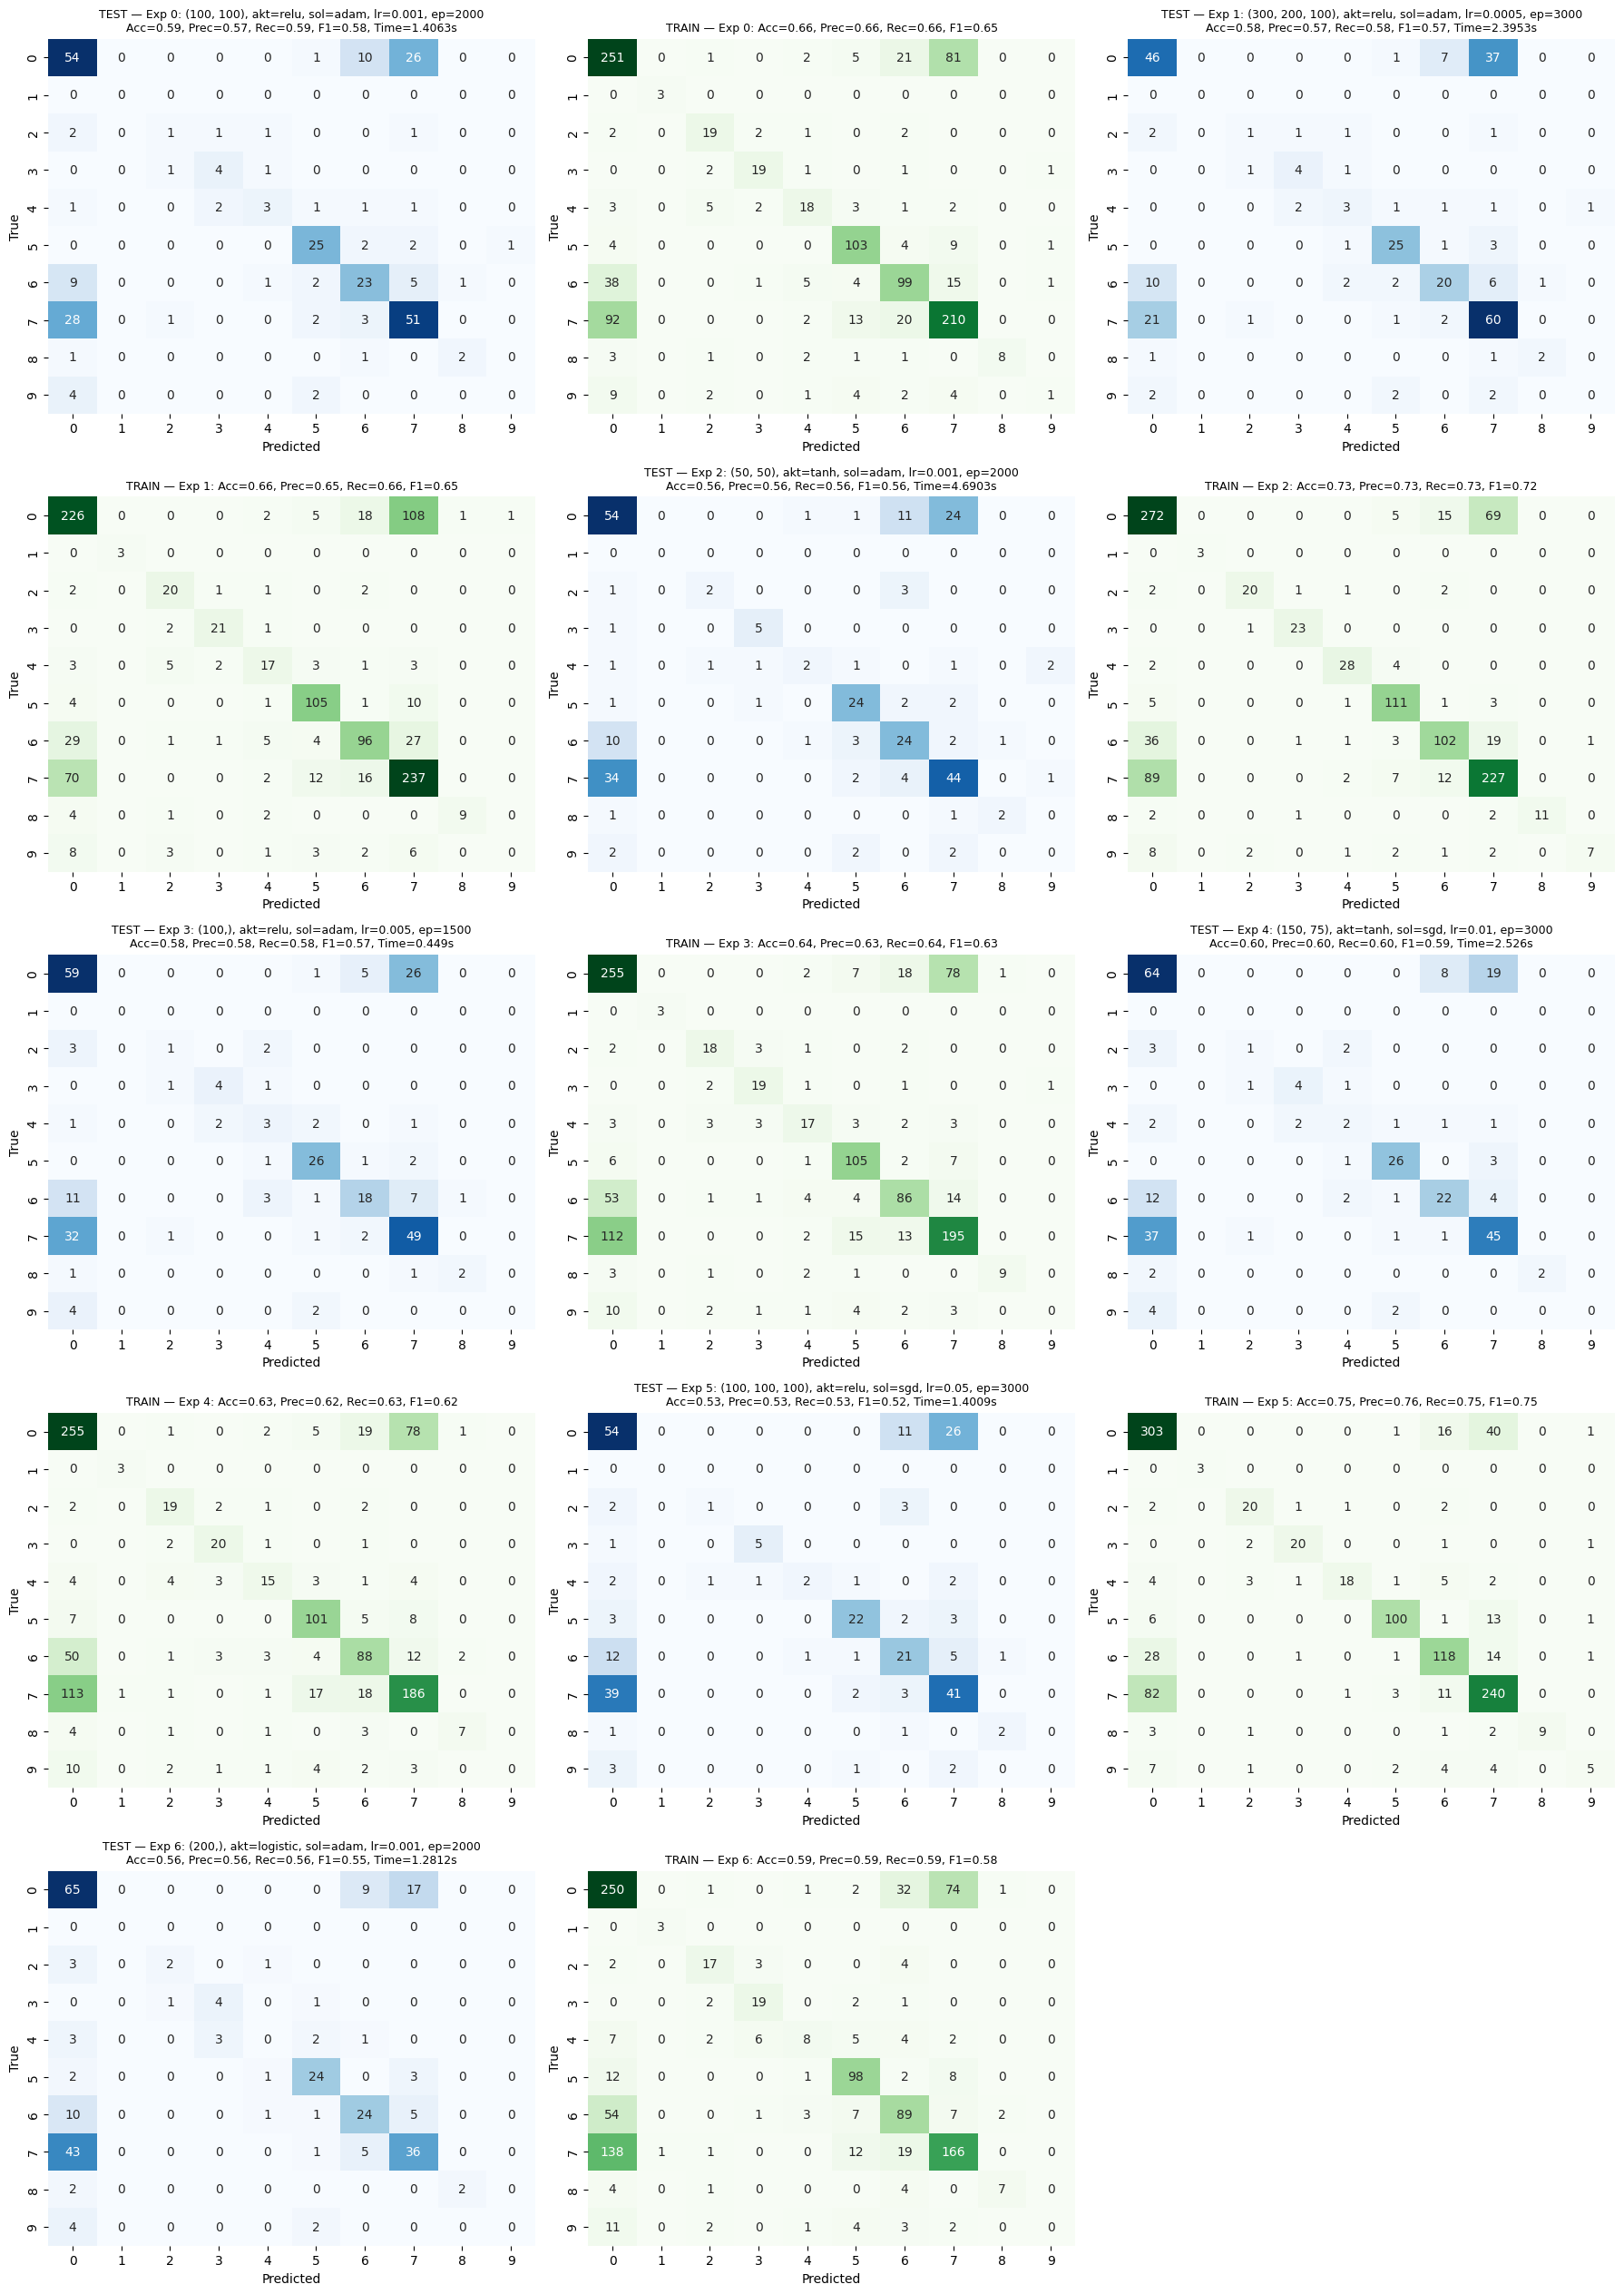

In [36]:
results = []

cols = 3
rows = 2 * ((len(experiments) + cols - 1) // cols) 
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, exp in enumerate(experiments):
    model = sk.neural_network.MLPClassifier(
        hidden_layer_sizes=exp['arch'],
        activation=exp['activation'],
        solver=exp['solver'],
        learning_rate_init=exp.get('learning_rate_init'),
        max_iter=exp['max_iter'],
        random_state=42,
        early_stopping=False
    )

    start = tm.time()
    model.fit(X_train, y_train)
    end = tm.time()
    training_time = round(end - start, 4)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # METRYKI TEST
    acc_test = sk.metrics.accuracy_score(y_test, y_test_pred)
    prec_test = sk.metrics.precision_score(y_test, y_test_pred, average='weighted')
    rec_test = sk.metrics.recall_score(y_test, y_test_pred, average='weighted')
    f1_test = sk.metrics.f1_score(y_test, y_test_pred, average='weighted')

    # METRYKI TRAIN
    acc_train = sk.metrics.accuracy_score(y_train, y_train_pred)
    prec_train = sk.metrics.precision_score(y_train, y_train_pred, average='weighted')
    rec_train = sk.metrics.recall_score(y_train, y_train_pred, average='weighted')
    f1_train = sk.metrics.f1_score(y_train, y_train_pred, average='weighted')

    unique_labels = np.unique(yf)
    cm_test = sk.metrics.confusion_matrix(y_test, y_test_pred, labels=unique_labels)
    cm_train = sk.metrics.confusion_matrix(y_train, y_train_pred, labels=unique_labels)


    # TEST
    ax_test = axes[2 * i]
    sns.heatmap(cm_test, annot=True, fmt="d", cmap='Blues', ax=ax_test, cbar=False)
    ax_test.set_title(
        f"TEST — Exp {i}: {exp['arch']}, akt={exp['activation']}, sol={exp['solver']}, "
        f"lr={exp.get('learning_rate_init', 'default')}, ep={exp['max_iter']}\n"
        f"Acc={acc_test:.2f}, Prec={prec_test:.2f}, Rec={rec_test:.2f}, F1={f1_test:.2f}, Time={training_time}s",
        fontsize=9
    )
    ax_test.set_xlabel('Predicted')
    ax_test.set_ylabel('True')

    # TRAIN
    ax_train = axes[2 * i + 1]
    sns.heatmap(cm_train, annot=True, fmt="d", cmap='Greens', ax=ax_train, cbar=False)
    ax_train.set_title(
        f"TRAIN — Exp {i}: Acc={acc_train:.2f}, Prec={prec_train:.2f}, "
        f"Rec={rec_train:.2f}, F1={f1_train:.2f}",
        fontsize=9
    )
    ax_train.set_xlabel('Predicted')
    ax_train.set_ylabel('True')

    results.append({
        'Eksperyment': i,
        'Architektura': str(exp['arch']),
        'Aktywacja': exp['activation'],
        'Solver': exp['solver'],
        'LR': exp.get('learning_rate_init', 'default'),
        'Train Acc': acc_train,
        'Train Precision': prec_train,
        'Train Recall': rec_train,
        'Train F1': f1_train,
        'Test Acc': acc_test,
        'Test Precision': prec_test,
        'Test Recall': rec_test,
        'Test F1': f1_test,
        'Training Time': training_time,
    })

for j in range(2 * len(experiments), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.savefig("macierze_pomylek_train_test_yeast.png", dpi=300)
plt.show()


## Wnioski

Przetestowano wiele konfiguracji i najlepsza jaką udało się uzyskać pod względem F1 score (0.59) to konfiguracja piąta(exp 4). Po wypisaniu macierzy pomyłek można zauważyc, że dane są nierówne i liczności klas znacząco się różnią od siebie. Zgodnie z rozpiską na stronie z którego można było pobrać zbiór to średnia skuteczności(accuracy) modeli opartych na sieciach neuronowych to około 0.56 także uznaje mój model za udany. 
Dodatkowo zmierzono czas uczenia się modeli i w związku z tym, że wyniki różnych modeli są bardzo podobne można uznać, że w niektórych przypadkach lepiej wybrać model delikatnie gorszy celem uzyskania lepszego czasu uczenia. 
Kolejnym spostrzeżeniem może być fakt, że klasa 10 nie została wytypowana ani razu poprawnie w zbiorze testowym, co prawdopodobnie jest skutkiem nierównomiernych danych.
Co więcej 2 modele wykazały poważne symptomy przeuczenia (exp 2, exp 5), czyli skuteczność (acc) podczas dopasowania na danych uczących była znacząco wyższa niż na danych testowych. 